In [1]:
!pip install transformers torch pandas scikit-learn

In [2]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import XLNetTokenizer, XLNetForSequenceClassification
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import logging



/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
df = pd.read_csv("/kaggle/input/dataset/final_dataset")

In [4]:
class CustomDataset(Dataset):
    def __init__(self, data, tokenizer, max_length):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

        
        self.label_encoder = LabelEncoder()
        self.label_encoder.fit(data['Sentiment']) 

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        review = self.data.iloc[idx]['reviewText']
        sentiment = self.data.iloc[idx]['Sentiment']

        encoding = self.tokenizer(review, padding='max_length', truncation=True, max_length=self.max_length, return_tensors='pt')

        #to convert sentiment labels to numerical labels
        sentiment = self.label_encoder.transform([sentiment])[0]

        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(sentiment, dtype=torch.long)  # Convert labels to torch.long
        }


if torch.cuda.device_count():
    print("Let's use", torch.cuda.device_count(), "GPU!")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
# Spliting dataset into train and validation
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)  

tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=True)
max_len=400

# Encode the dataset
train_dataset = CustomDataset(train_df, tokenizer, max_len)
val_dataset = CustomDataset(val_df, tokenizer,max_len)

model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased", num_labels=3)  # 3 labels: Positive, Negative, Neutral

# Moving the model to the selected device
model = model.to(device)


Let's use 2 GPU!


Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
#Data loaders
batch_size = 20
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

#loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-5)

In [6]:
#training 5-10 epochs
model.load_state_dict(torch.load('/kaggle/input/model5/my_model.pth'))


# Lists to store loss and accuracy values for each epoch
loss_values = []
accuracy_values = []
num_epochs = 10  

for epoch in range(5, num_epochs):
    model.train()
    total_loss = 0.0

    for batch in tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}", dynamic_ncols=True):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        labels = labels.long()

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(train_dataloader)

    logging.info(f"Epoch {epoch + 1}/{num_epochs} - Average Loss: {average_loss:.4f}")

    # Calculate and store accuracy
    model.eval()
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            predicted_labels = torch.argmax(logits, dim=1)
            correct_predictions += torch.sum(predicted_labels == labels).item()
            total_predictions += len(labels)

    accuracy = correct_predictions / total_predictions
    accuracy_values.append(accuracy)
    loss_values.append(average_loss)
    print(f"Epoch {epoch + 1}/{num_epochs} - Average Loss: {average_loss:.4f} - Accuracy: {accuracy * 100:.2f}%")

model.save_pretrained('trained_model')
torch.save(model.state_dict(), 'my_model.pth')



Epoch 6/10: 100%|██████████| 720/720 [31:29<00:00,  2.62s/it]


Epoch 6/10 - Average Loss: 0.0750 - Accuracy: 90.53%


Epoch 7/10: 100%|██████████| 720/720 [31:27<00:00,  2.62s/it]


Epoch 7/10 - Average Loss: 0.0725 - Accuracy: 90.78%


Epoch 8/10: 100%|██████████| 720/720 [31:27<00:00,  2.62s/it]


Epoch 8/10 - Average Loss: 0.0563 - Accuracy: 91.19%


Epoch 9/10: 100%|██████████| 720/720 [31:28<00:00,  2.62s/it]


Epoch 9/10 - Average Loss: 0.0477 - Accuracy: 90.06%


Epoch 10/10: 100%|██████████| 720/720 [31:27<00:00,  2.62s/it]


Epoch 10/10 - Average Loss: 0.0376 - Accuracy: 87.81%


In [7]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tqdm import tqdm
import numpy as np
import torch.nn as nn


test_accuracies = []
all_predicted_labels = []
all_true_labels = []

model = model.to(device)
model.eval()

with torch.no_grad():
    for batch in tqdm(val_dataloader, desc="Validation", dynamic_ncols=True):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        predicted_labels = torch.argmax(logits, dim=1)
        all_predicted_labels.extend(predicted_labels.cpu().numpy())
        all_true_labels.extend(labels.cpu().numpy())


accuracy = accuracy_score(all_true_labels, all_predicted_labels)
classification_rep = classification_report(all_true_labels, all_predicted_labels, target_names=["Positive", "Neutral", "Negative"])
confusion = confusion_matrix(all_true_labels, all_predicted_labels)



Validation: 100%|██████████| 180/180 [04:17<00:00,  1.43s/it]


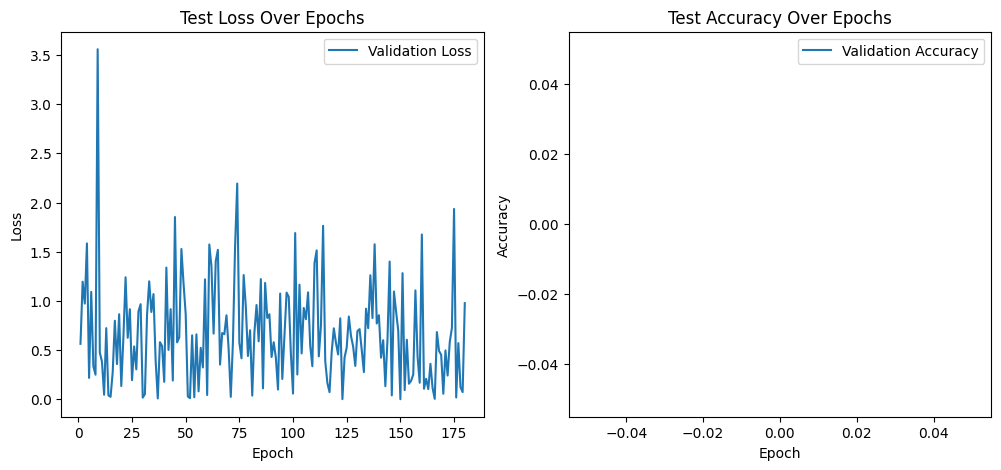

Test Accuracy: 87.81%
Classification Report:
              precision    recall  f1-score   support

    Positive       0.95      0.90      0.92      1210
     Neutral       0.77      0.95      0.85      1193
    Negative       0.96      0.78      0.86      1197

    accuracy                           0.88      3600
   macro avg       0.89      0.88      0.88      3600
weighted avg       0.89      0.88      0.88      3600



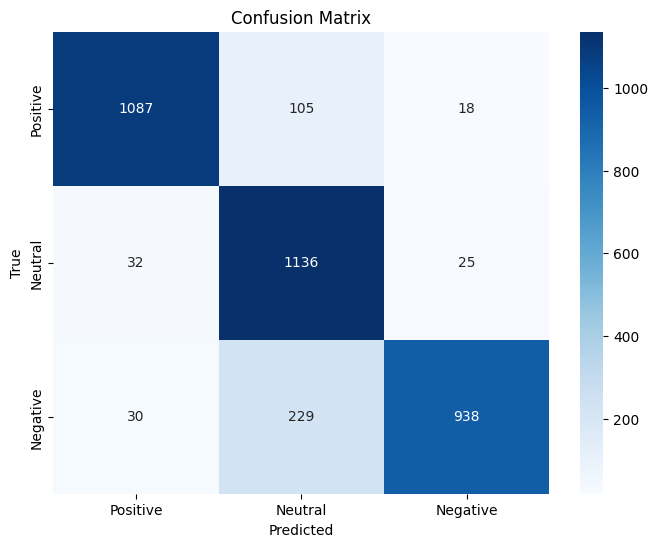

In [8]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(validation_losses) + 1), validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(validation_accuracies) + 1), validation_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy Over Epochs')
plt.legend()

plt.show()

# Display accuracy and classification report
print(f'Test Accuracy: {accuracy * 100:.2f}%')
print('Classification Report:')
print(classification_rep)

# Display confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=["Positive", "Neutral", "Negative"], yticklabels=["Positive", "Neutral", "Negative"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
